# Setup

## Create Filesystem
This notebook is primarily meant to be executed in Colab as a computational backend. If you want to run on your own hardware with data, you need to set `data_dir` and `ALLOW_IO`

This notebook viewable directly on Colab from [https://colab.research.google.com/github/rcharan/phutball/blob/rl/pytorch-implementation/model-training.ipynb](https://colab.research.google.com/github/rcharan/phutball/blob/rl/pytorch-implementation/model-training.ipynb) (it is a mirror of github). But if it has moved branches or you are looking at a past commit, look at the [Google instructions](https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb) on where to find this file.

The workflow is:
 - Data stored in (my personal/private) Google Drive
 - Utilities/library files (for importing) on github, edited on local hardware and pushed to github.
 - Notebook hosted on github, edited both in Colab or locally (depending on the relative value of having a GPU attached versus being able to use regular Jupyter keyboard shortcuts/a superior interface)

In [1]:
# Attempt Colab setup if on Colab
try:
  import google.colab
except:
  ALLOW_IO = False
else:
  # Mount Google Drive at data_dir
  #  (for data)
  from google.colab import drive
  from os.path import join
  ROOT = '/content/drive'
  DATA = 'My Drive/phutball'
  drive.mount(ROOT)
  ALLOW_IO = True
  data_dir = join(ROOT, DATA)
  !mkdir "{data_dir}"     # in case we haven't created it already   

  # Pull in code from github
  %cd /content
  github_repo = 'https://github.com/rcharan/phutball'
  !git clone -b rl {github_repo}
  %cd /content/phutball
  
  # Point python to code base
  import sys
  sys.path.append('/content/phutball/pytorch-implementation')

  # Updater for library functions changed on local hardware and pushed to github
  #  (circuitous, I know)
  def update_repo():
    !git pull

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/My Drive/phutball’: File exists
/content
Cloning into 'phutball'...
remote: Enumerating objects: 190, done.
remote: Counting objects: 100% (190/190), done.
remote: Compressing objects: 100% (136/136), done.
remote: Total 1572 (delta 121), reused 107 (delta 53), pack-reused 1382
Receiving objects: 100% (1572/1572), 6.40 MiB | 22.77 MiB/s, done.
Resolving deltas: 100% (949/949), done.
/content/phutball


## Imports

In [0]:
%%capture

%load_ext autoreload
%autoreload 2

import os
import gc
import numpy as np

# Codebase
from lib.model_v2          import TDConway
from lib.off_policy        import EpsilonGreedy
from lib.optim             import AlternatingTDLambda

from lib.training          import training_loop

from lib.utilities         import config, lfilter
from lib.testing_utilities import create_state, visualize_state, boards
from lib.timer             import Timer

from lib.move_selection    import get_next_move_training


# Graphics for visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
%matplotlib inline
plt.ioff()

# PyTorch
import torch

## Device Management Utilities
Setup for GPU, CPU, or (not working well/fully implemented) TPU

In [3]:
use_tpu = False

if use_tpu:
  # Install PyTorch/XLA
  VERSION = "nightly" #["20200220","nightly", "xrt==1.15.0"]
  !curl https://raw.githubusercontent.com/pytorch/xla/master/contrib/scripts/env-setup.py -o pytorch-xla-env-setup.py
  !python pytorch-xla-env-setup.py --version $VERSION
  import torch_xla
  import torch_xla.core.xla_model as xm
  
  # Set the device
  device = xm.xla_device()
  
  # Memory inspection
  def print_memory_usage():
    print('TPU memory inspection not implemented')
  def print_max_memory_usage():
    print('TPU memory inspection not implemented')
  def garbage_collect():
    gc.collect() # No TPU specific implementation yet
    
elif torch.cuda.is_available():
  # Set the device
  device = torch.device('cuda')
  
  # Echo GPU info
  gpu_info = !nvidia-smi
  gpu_info = '\n'.join(gpu_info)
  print(gpu_info)
  
  # Memory inspection and management
  from lib.memory import (
    print_memory_usage_cuda     as print_memory_usage,
    print_max_memory_usage_cuda as print_max_memory_usage,
    garbage_collect_cuda        as garbage_collect
  )

else:
  # Set the device to CPU
  device = torch.device('cpu')
  
  # Echo RAM info
  from psutil import virtual_memory
  from lib.memory import format_bytes
  ram = virtual_memory().total
  print(format_bytes(ram), 'available memory on CPU-based runtime')
  
  # Memory inspection and management
  from lib.memory import (
    print_memory_usage, 
    print_max_memory_usage,
    garbage_collect
  )

Fri May 15 05:25:04 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    26W / 250W |     10MiB / 16280MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Execution

In [0]:
def save(fname, model, optimizer):
  state_dict = {
      'model' : model.state_dict(),
      'optim' : optimizer.state_dict()
  }
  torch.save(state_dict, f'{data_dir}/{fname}.pt')

In [0]:
def fname(version, game_num):
  return f'v{version}-{game_num}'

## Instantiate

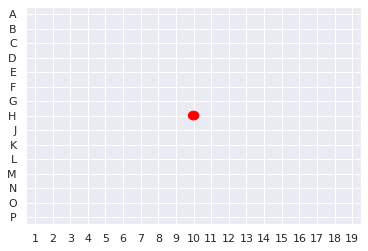

In [8]:
epsilon_greedy = EpsilonGreedy(0.1)

initial_state = create_state('H10').to(device)
visualize_state(initial_state)

## Profile

In [11]:
%timeit get_next_move_training(initial_state, model, device)
%prun training_loop(model, optimizer, 1, device, off_policy = epsilon_greedy)

100 loops, best of 3: 11.7 ms per loop

Playing game 1 of 1:
121/121 [==============================] - 4s 30ms/step
 

## Pre-train
Teach the model that

In [0]:
from lib.pre_training import random_board_batch

In [0]:
from lib.training import ProgressBar

In [0]:
import torch.nn.functional as F
from torch.optim import SGD

In [29]:
loops      = 10000
batch_size = 300
np.random.seed(42)

model = TDConway(config).to(device)
optimizer = SGD(model.parameters(), lr = 0.01)

min_density = 0
max_density = 0.3

bar = ProgressBar(loops, expandable = False)
for _ in range(loops):
  boards, targets = random_board_batch(
      min_density, 
      max_density, 
      batch_size,
      device
  )

  targets.mul_(1/config.cols)

  predictions = model(boards, get_all_values = True)
  loss        = F.mse_loss(predictions, targets)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  bar.step()

10000/10000 [==============================] - 395s 39ms/step


In [0]:
version = '0.2.1'
game_num = 'pre10000x300'

save(fname(version, game_num), model, optimizer)

## Run!

In [0]:
model = TDConway(config).to(device)
optimizer = AlternatingTDLambda(model.parameters(), 0.01, 0.9)

version = '0.2.1'
game_num = 1500

sd = torch.load(f'{data_dir}/{fname(version, game_num)}.pt', map_location = device)
model.load_state_dict(sd['model']);

In [17]:
training_loop(model, optimizer, 2000, device, off_policy = epsilon_greedy, verbose = 1)

2000/2000 [==============================] - 5944s 3s/step


In [0]:
game_num = 3500
save(fname(version, game_num), model, optimizer)

In [27]:
from datetime import datetime
from pytz import timezone
eastern = timezone('US/Eastern')
print(f'Finished {game_num} games at', datetime.now(eastern).strftime('%I:%M%p %Z'))

Finished 3500 games at 04:58AM EDT


In [26]:
print(f'Finished {game_num} games at', datetime.now(timezone.est).strftime('%I:%M%p %Z'))

AttributeError: ignored

In [31]:
from datetime import datetime
from pytz import timezone
eastern = timezone('US/Eastern')

def save(fname, model):
  state_dict = {
      'model' : model.state_dict(),
  }
  torch.save(state_dict, f'{data_dir}/{fname}.pt')

game_num = 4000
version = '0.2.1'

batch_size = 500

model = TDConway(config).to(device)
optimizer = AlternatingTDLambda(model.parameters(), 0.01, 0.9)
sd = torch.load(f'{data_dir}/{fname(version, game_num)}.pt', map_location = device)
model.load_state_dict(sd['model']);


while True: # Until Colab disconnects out of anger
  training_loop(model, optimizer, batch_size, device, off_policy = epsilon_greedy, verbose = 1)
  game_num += batch_size

  save(fname(version, game_num), model)

  print(f'Finished {game_num} games at', datetime.now(eastern).strftime('%I:%M%p %Z'))  

500/500 [==============================] - 1565s 3s/step
Finished 4500 games at 05:53AM EDT
500/500 [==============================] - 1539s 3s/step
Finished 5000 games at 06:19AM EDT
500/500 [==============================] - 1542s 3s/step
Finished 5500 games at 06:45AM EDT
500/500 [==============================] - 1804s 4s/step
Finished 6000 games at 07:15AM EDT
500/500 [==============================] - 2266s 5s/step
Finished 6500 games at 07:53AM EDT
500/500 [==============================] - 2985s 6s/step
Finished 7000 games at 08:42AM EDT
500/500 [==============================] - 2990s 6s/step
Finished 7500 games at 09:32AM EDT
500/500 [==============================] - 3032s 6s/step
Finished 8000 games at 10:23AM EDT
500/500 [==============================] - 2999s 6s/step
Finished 8500 games at 11:13AM EDT
500/500 [==============================] - 2715s 5s/step
Finished 9000 games at 11:58AM EDT
500/500 [==============================] - 2933s 6s/step
Finished 9500 games at 

KeyboardInterrupt: ignored

In [0]:
# Versioning:
#  Major versions - major change in approach
#  Minor versions - incompatible architecture tweaks
#  Build          - retraining or changes in training parameters
#  Game number    - number of games trained or pre{E}x{B} where E is the the
#                   number of batches and B is the batch size for pre-training
# Example: v0.1.2 @400 is the second attempt at training the v0.1 architecture
#  and was trained for 400 games

# Performance benchmarks.
#  GPU benchmarks are on a P100 unless otherwise stated
#    per move    : training-relevant
#    forward pass: evaluation (arena mode) relevant
#  CPU benchmarks are for inference on a fixed set of 300 randomly
#    generated boards on an Intel i5 chipset. (deployment-relevant)
#  Memory consumption has not been an issue

# v0.1: architecture from model_v1. Training: Alternating TD(λ)
#  ~60M params (59,943,809)
#  GPU: 100–110ms/move with 50-60ms for forward pass
#  CPU: 8.1s ± 0.5s 
#
#  - v0.1.1 - don't use, bug in training
#  - v0.1.2 - Use. available @400. Win rate v RandoTron 51% (😢)

# v0.2: architecture from model_v2.
#  Training: Alternating TD(λ) WITH pretraining to prefer the ball to the
#   right on randomly generated boards
#  ~4.4M params (4,381,505)
#  GPU: 30-35ms/move with ~12ms for forward pass
#  CPU: 1.1s ± 0.02s
#
# - v0.2.1 - Available @pre10000x300, @400, @1500, @3500
#            Win rate v RandoTron 
#            - @400: 49%
#            - @1500: 56.9% ±1.8%
#            - @3500: 54.8% ±1.7%
#            - In further increments of 500 as [4000, 4500, ..., ]

# Evaluate

In [0]:
from lib.arena import Player, Battle, RandoTron

In [0]:
model = TDConway(config).to(device)
version  = '0.2.1'
game_num = 3500
sd = torch.load(f'{data_dir}/{fname(version, game_num)}.pt', map_location = device)
model.load_state_dict(sd['model'])
# optimizer.load_state_dict(sd['optim'])

td_conway = Player(model, name = f'TD Conway v{version} @{game_num}')
td_conway.eval()
randotron = RandoTron()
battle    = Battle(td_conway, randotron, verbose = 1)

In [21]:
battle.play_match(900, device)

900/900 [==============================] - 448s 498ms/step
900 games were played between TD Conway v0.2.1 @1500 and RandoTron with 0 draws.
The winner was TD Conway v0.2.1 @1500 with a 54.8% win rate!
Player 1 on average won in a game of length 95.5.
Player 2 on average won in a game of length 84.8
Overall average length of game was 90.7
Total time taken: 7:28 at
 - 498ms per finished game.
 - 5ms per move in a finished game
